# Imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

%matplotlib notebook

# Tests

## Get a list of fonts

In [2]:
from matplotlib import font_manager
from IPython.core.display import HTML
font_manager.fontManager.addfont('/home/kevin/.local/share/fonts/Polly-Regular.otf')

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in mpl.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

## Define sinusoidal curves for the different pngs

In [3]:
pngs = {Path(file): {} for file in glob('logo/*banner*png')}

offset = 0.4
nsamples = 20
xall = np.linspace(0, (np.pi + offset) * len(pngs), nsamples * len(pngs))
yall = np.full(nsamples * len(pngs), 0).astype(float)
zeros = np.full(nsamples * len(pngs), 0).astype(float)

for i, png in enumerate(pngs):
    x = np.linspace(-offset, np.pi, nsamples)
    y = np.sin(x) * 1.05
    y[y>1] = 1
    y[x < 0] = 0
    x += offset
    yall[i * nsamples:i*nsamples + nsamples] = y
    zeros[i * nsamples:i*nsamples + nsamples] = y
    pngs[png]['x'] = xall
    pngs[png]['y'] = zeros
    zeros = np.full(nsamples * len(pngs), 0).astype(float)

<IPython.core.display.Javascript object>


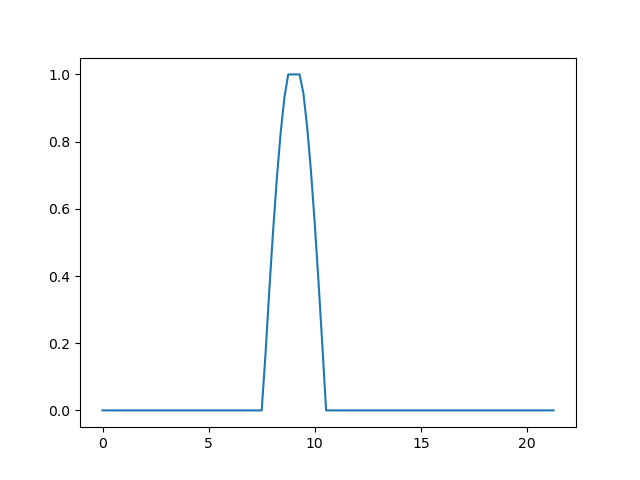

In [4]:
plt.plot(pngs[Path('logo/github_banner_molecule.png')]['x'], pngs[Path('logo/github_banner_molecule.png')]['y'])

## Test animation

<IPython.core.display.Javascript object>


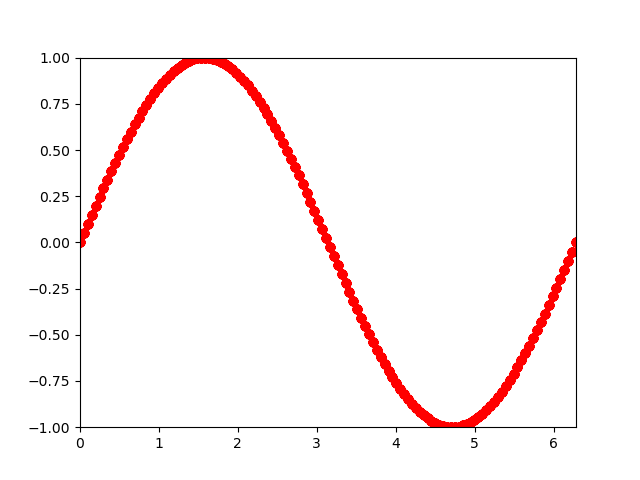

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

# Plotting

<IPython.core.display.Javascript object>


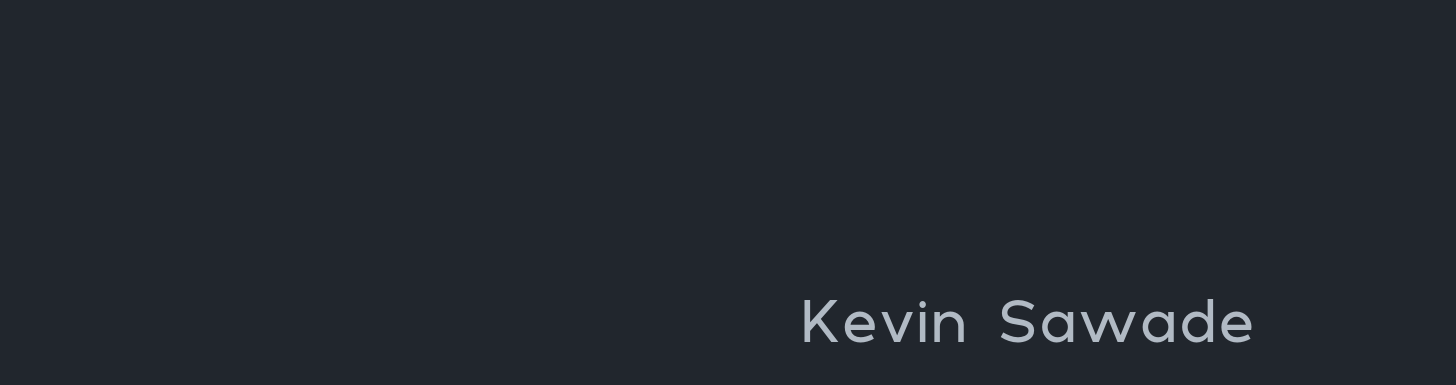

In [14]:
from matplotlib import font_manager
from matplotlib.animation import FuncAnimation, PillowWriter
font_manager.fontManager.addfont('/home/kevin/.local/share/fonts/Polly-Regular.otf')

# settings
dpi = 200
canvas_width = 1456
canvas_height = 385
offset = 0.4
nsamples = 20

# constants
bg_color = '#21262d'
fg_color = '#b1bac4'
highlight_color1 = '#cccccc'
highlight_color2 = '#ffffff'

# prepare data
pngs = {Path(file): {} for file in glob('logo/*banner*png')}

xall = np.linspace(0, (np.pi + offset) * len(pngs), nsamples * len(pngs))
frames = np.arange(nsamples * len(pngs))
yall = np.full(nsamples * len(pngs), 0).astype(float)
zeros = np.full(nsamples * len(pngs), 0).astype(float)

for i, png in enumerate(pngs):
    x = np.linspace(-offset, np.pi, nsamples)
    y = np.sin(x) * 1.05
    y[y>1] = 1
    y[x < 0] = 0
    x += offset
    yall[i * nsamples:i*nsamples + nsamples] = y
    zeros[i * nsamples:i*nsamples + nsamples] = y
    pngs[png]['x'] = xall
    pngs[png]['y'] = zeros
    zeros = np.full(nsamples * len(pngs), 0).astype(float)
    pngs[png]['img'] = plt.imread(png)[::-1]
    index = pngs[png]['img'][..., -1] != 0
    pngs[png]['index'] = index
    
# create one unifying array with largest size
max_x = 0
max_y = 0
for ar_shape in [a['img'].shape for a in pngs.values()]:
    if ar_shape[0]  > max_y:
        max_y = ar_shape[0]
    if ar_shape[1] > max_x:
        max_x = ar_shape[1]
        
for png in pngs:
    zeros = np.full((max_y, max_x, 4), 0).astype(float)
    zeros[:pngs[png]['img'].shape[0], :pngs[png]['img'].shape[1]] = pngs[png]['img']
    assert np.any(zeros != 0)
    pngs[png]['img'] = zeros
    index = pngs[png]['img'][..., -1] != 0
    pngs[png]['index'] = index
    
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(canvas_width/dpi, canvas_height/dpi), dpi=dpi)

# prepare the ax
ax1.axis('off')
ax2.axis('off')
fig.patch.set_facecolor(bg_color)

# add the Kevin Sawade Text
text = ax2.text(800, 29, 'Kevin Sawade', ha='left', va='bottom', c=fg_color, transform=None, fontdict={'size': 22, 'family': 'Polly'})
im = ax1.imshow(pngs[png]['img'])
    
def init():
    ar = im.get_array()
    ar[..., -1] = 0
    im.set_array(ar)
    return [im]
        
def animate(i):
    arrs = []
    for png in pngs:
        ar = pngs[png]['img']
        alpha = pngs[png]['y'][i]
        ar[pngs[png]['index'], -1] = alpha
        if alpha > 0:
            break
    im.set_array(ar[::-1])
    return [im]
        

ani = FuncAnimation(fig, animate, frames=frames,
                    init_func=init, blit=True, interval=5,
                    repeat=False)
# ani.save("logo/frames/anim.png", writer="imagemagick", dpi=dpi)
ani.save("logo/frames/movie.gif", writer=PillowWriter(fps=5))
# plt.show()

In [178]:
np.sum(np.stack([v['img'] for v in pngs.values()]), 0).shape

(1110, 1413, 4)

In [183]:
np.unique(pngs[png]['img'])

array([0, 1])